# Tutorial - Fault-Tolerant Quantum Computing with CSS codes

Source:  https://github.com/NordIQuEst/application-library/blob/main/training-material/qas2024/notebooks/css_code_steane.ipynb

In this notebook we'll explore how fault-tolerant quantum computing looks like at the **circuit-level**.



## Optional: Simulating the Steane Code on noisy Hardware: Quantinuum Experiment

The Steane code has been realized in various experiments:
- [Quantum computations on a topologically encoded qubit](https://www.science.org/doi/10.1126/science.1253742), 2014, Nigg et al.
- [Realization of Real-Time Fault-Tolerant Quantum Error Correction](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.041058), 2021
- [Demonstration of logical qubits and repeated error correction with better-than-physical error rates](https://arxiv.org/html/2404.02280v1), 2024

In the following, we provide code to simulate parts of the experiment by Quantinuum in 2021, where they implemented a single logical qubit on their ion-trap device and applied multiple rounds of error correction to it.

This will hopefully give you a better understanding of how rounds of quantum error correction are actually implemented and how errors are handled. Please refer to the paper to learn more about the details of the experiment. Happy exploring!

### Introducing Errors

#### Quantinuum error parameters

In their experiment, Quantinuum measured various error sources for their ion-trap device. H1-1 2024  noise level


| Operation | Error Channel | Probability |
|---|---|---|
| Initilization | Bit flip | $1.66 \cdot 10^{-6}$ |
| Measurement |  Bit flip | $2.4 \cdot  10^{-3}$ |
| Single-qubit gate | Depolarizing | $7 \cdot 10^{-5}$ |
| Two-qubit gate | Depolarizing | $3.1 \cdot 10^{-3}$ |

**Note:** We excluded non-Pauli channels, such as leakage, as they cannot be handled by Stim.

Below, we define a helper function that allows us to inject the noise defined in the paper into our circuits: 

In [1]:
import numpy as np
import stim
print('stim:',stim.__version__)
import pymatching
print('pymatching:',pymatching.__version__)

stim: 1.16.dev0
pymatching: 2.3.1


In [2]:
import matplotlib.pyplot as plt

In [3]:
class NoiseModel:
    """Applies noise to quantum circuits.

    Adds depolarizing noise after 1 and 2-qubit gates, measurement errors,
    and initialization errors based on typical H1-1 Quantinuum qubit parameters.
    For idle_error_rate see: https://docs.google.com/document/d/1g87ybc5MC67lVpsVeHywJN23OKudImh7-0nCdWBX3Xo/edit?usp=sharing  
    """

    def __init__(self, type='H1-1'):
        assert type in ['H1-1','H2-1']
        if type=='H1-1':
            self.init_error = 1.66 * 1e-6
            self.meas_error = 2.4 * 1e-3
            self.depolarize1 = 7 * 1e-5
            self.depolarize2 = 3.1 * 1e-3
            self.idle_error_rate = 2e-4  # per tick
        if type=='H2-1':
            self.init_error = 4 * 1e-5
            self.meas_error = 1.4 * 1e-3
            self.depolarize1 = 1.9 * 1e-5
            self.depolarize2 = 1.1 * 1e-3
            self.idle_error_rate = 1e-4  # per tick
        self.type=type
        self.enabled = True
        print('noise type=',type)
        # Define an idle error rate (approx T1/T2 over gate time)
        # e.g., if T1=100us and gate=100ns, rate ~ 1e-3
        self.idle_error_rate = 1e-4
    
    def apply(self, c: stim.Circuit) -> stim.Circuit:
        if not self.enabled:
            return c

        cn = stim.Circuit()
        num_qubits = c.num_qubits  # Dynamic system size
        
        # Buffer to hold ops between TICKS
        moment_ops = []
        busy_qubits = set()

        for op in c:
            if op.name == "TICK":
                # 1. Process all active gates in this moment
                for buffered_op in moment_ops:
                    self._append_noisy_op(cn, buffered_op)

                # 2. Apply idle error to everyone else
                #    (All qubits - Busy qubits)
                idle_qubits = [q for q in range(num_qubits) if q not in busy_qubits]
                if idle_qubits:
                    cn.append("DEPOLARIZE1", idle_qubits, self.idle_error_rate)

                # 3. Close the moment
                cn.append("TICK")
                moment_ops = []
                busy_qubits = set()
                continue

            # Accumulate busy qubits for this moment
            for t in op.targets_copy():
                busy_qubits.add(t.value)
            
            moment_ops.append(op)

        # Handle any trailing operations (if circuit doesn't end with TICK)
        for buffered_op in moment_ops:
            self._append_noisy_op(cn, buffered_op)

        return cn

    def _append_noisy_op(self, cn: stim.Circuit, op: stim.CircuitInstruction):
        """Helper to append a gate and its specific noise."""
        cn.append(op)
        
        # Add noise based on gate type
        if op.name == "CX":
            # Stim CX targets are pairs [c1, t1, c2, t2...]
            targets = [t.value for t in op.targets_copy()]
            for i in range(0, len(targets), 2):
                cn.append("DEPOLARIZE2", [targets[i], targets[i+1]], self.depolarize2)
        
        elif op.name in ["H", "X", "Y", "S", "S_DAG"]:
            cn.append("DEPOLARIZE1", op.targets_copy(), self.depolarize1)
            
        elif op.name == "M":
            cn.append("X_ERROR", op.targets_copy(), self.meas_error)
            
        elif op.name == "R":
            cn.append("X_ERROR", op.targets_copy(), self.init_error)

In [4]:
def encoding_circuit(log_qb_idx: int = 0) -> stim.Circuit:
    """Encoding scheme proposed by Goto 2015:
        https://www.nature.com/articles/srep19578

    To prepare the logical Steane qubit in state |0>_L.
    The qubit index allows shifting the indices so that
    we can prepare multiple logical qubits.
    """
    c = stim.Circuit()
    # shift registers to target logical qubit with given index
    s = log_qb_idx * 8

    c.append("H", [s, 4 + s, 6 + s])
    c.append("TICK")
    c.append("CNOT", [s, 1 + s])
    c.append("CNOT", [4 + s, 5 + s])
    c.append("CNOT", [6 + s, 3 + s])
    c.append("TICK")
    c.append("CNOT", [6 + s, 5 + s])
    c.append("CNOT", [4 + s, 2 + s])
    c.append("CNOT", [0 + s, 3 + s])
    c.append("TICK")
    c.append("CNOT", [4 + s, 1 + s])
    c.append("CNOT", [3 + s, 2 + s])
    
    # Entangle with ancilla qubit and measure logical Pauli-Z
    c.append("CNOT", [1 + s, 7 + s])
    c.append("TICK")
    c.append("CNOT", [3 + s, 7 + s])
    c.append("TICK")
    c.append("CNOT", [5 + s, 7 + s])
    c.append("TICK")
    #c.append("X", [7])
    c.append("M", [7 + s])

    return c

In [5]:
def measure_logical_qubits(log_qubit_indices: list[int] = [0]) -> stim.Circuit:
    c = stim.Circuit()
    for log_qubit_index in log_qubit_indices:
        # shift index
        s = log_qubit_index * 8
        # final measurement
        c.append("M", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
    c.append("TICK")
    return c

def sample_from_circuit(c: stim.Circuit, shots: int = 10) -> np.array:
    # compile a sampler and sample 10 shots
    s = c.compile_sampler()
    r = s.sample(shots=shots).astype(int)

    return r

### Faulty logical state preparation

To test our noise model, we apply it to the Goto scheme. We expect to see some state preparation failures.

In [6]:
noise = NoiseModel('H1-1')
c = stim.Circuit()
# prepare |0>_L
c += noise.apply(encoding_circuit())
# append final measurement
c += measure_logical_qubits()

noise type= H1-1


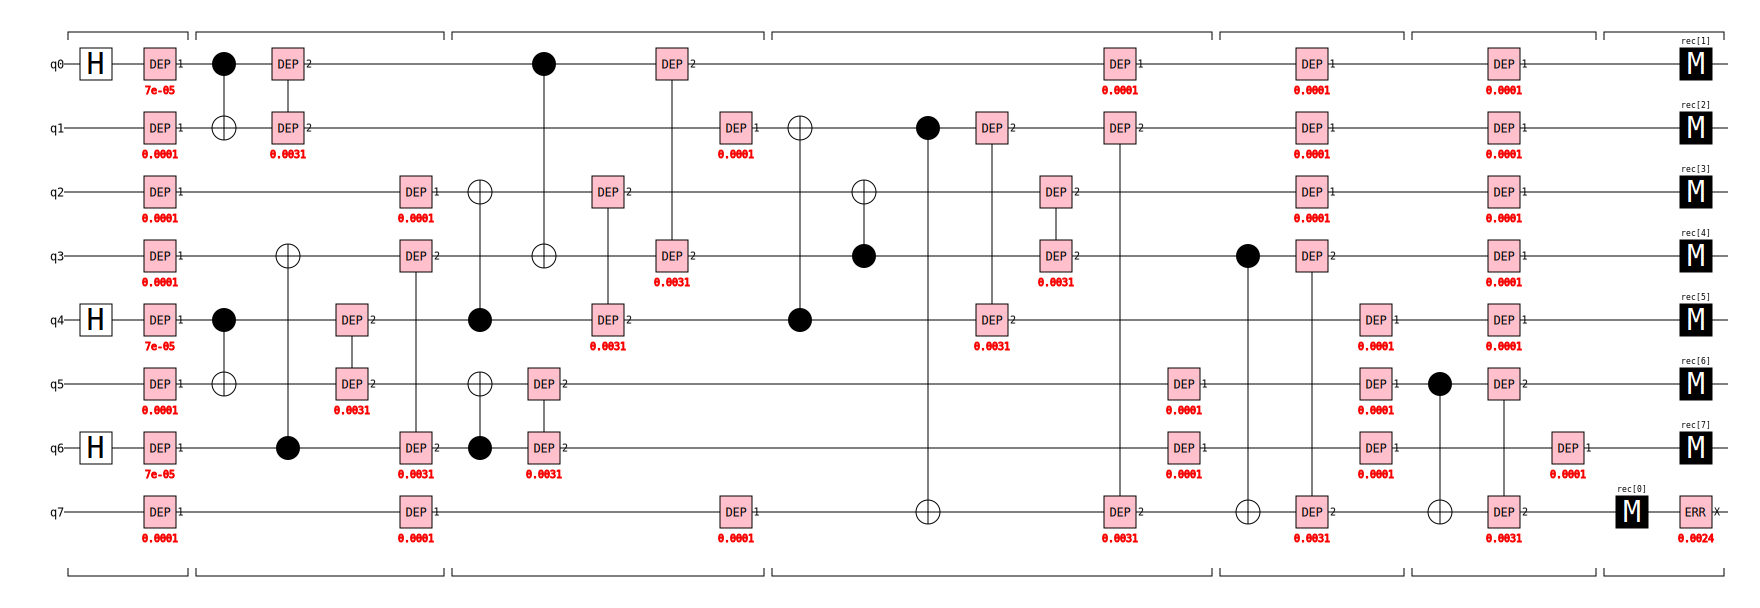

In [7]:
c.diagram("timeline-svg")

In [8]:
num_shots = 100_000
r = sample_from_circuit(c, shots=num_shots)
# compute Z_L observable from measurement
logical_measurement_output = r[:, 5] ^ r[:, 6] ^ r[:, 7]

In [9]:
# Measure how often the ancilla qubit is measured in state |0>
prob=(np.sum(r[:, 0]) / num_shots)
eprob=np.sqrt(prob*(1-prob)/num_shots)
print(f"Failure rate (%): { prob*100:.2f} +/- {eprob*100:.2f}")

Failure rate (%): 1.67 +/- 0.04


### Syndrome extraction

After succesful state preparation, the logical qubit is idling and the physical qubits will accumulate errors. This will cuase the logical qubit to decohere if we don't measure the stabilizers, effectively **digitizing the noise**, and tracking the changes in stabilizer measurements!

Below we first provide a function to measure all stabilizers of the code in a sequence.

In [10]:
def measure_all_syndromes() -> stim.Circuit:
    """Appends a circuit that measures all 6 stabilizers of the [[7,1,3]]-Steane code"""

    # indices for X-/Z-stabilizers
    syndrome_qubits = [
        [0, 1, 2, 3],  # 1st plaquette
        [1, 2, 4, 5],  # 2nd plaquette
        [2, 3, 5, 6],  # 3rd plaquette
    ]
    # indices for ancilla qubits
    ancilla_qubits = [8, 9, 10]

    c = stim.Circuit()
    # measure X-stabilizers
    for ancilla, data_qubits in zip(ancilla_qubits, syndrome_qubits):
        for data in data_qubits:
            c.append("CNOT", [data, ancilla])
        c.append("M", ancilla)
        c.append("R", ancilla)

    # measure Z-stabilizers
    for ancilla, data_qubits in zip(ancilla_qubits, syndrome_qubits):
        c.append("H", ancilla)
        for data in data_qubits:
            c.append("CNOT", [ancilla, data])
        c.append("H", ancilla)
        c.append("M", ancilla)
        c.append("R", ancilla)

    return c

In [11]:
def measure_all_syndromes_3ancPara() -> stim.Circuit:
    """
    Appends a circuit that measures all 6 stabilizers of the [[7,1,3]]-Steane code.
    Optimized for parallelism (depth 4 CNOTs) with explicit TICKs for noise modeling.
    """
    c = stim.Circuit()

    # Ancilla indices
    a1, a2, a3 = 8, 9, 10

    # ============================================
    # 1. Measure X-Stabilizers (Z-checks)
    # Gates: CNOT Data -> Ancilla
    # ============================================
    
    # Init ancillas
    c.append("R", [a1, a2, a3])
    c.append("TICK")

    # Round 1: No shared data qubits
    # A1(8) <-> 0, A2(9) <-> 4, A3(10) <-> 6
    c.append("CNOT", [0, a1, 4, a2, 6, a3])
    c.append("TICK")

    # Round 2
    # A1(8) <-> 1, A2(9) <-> 5, A3(10) <-> 2
    c.append("CNOT", [1, a1, 5, a2, 2, a3])
    c.append("TICK")

    # Round 3
    # A1(8) <-> 2, A2(9) <-> 1, A3(10) <-> 3
    c.append("CNOT", [2, a1, 1, a2, 3, a3])
    c.append("TICK")

    # Round 4
    # A1(8) <-> 3, A2(9) <-> 2, A3(10) <-> 5
    c.append("CNOT", [3, a1, 2, a2, 5, a3])
    c.append("TICK")

    # Measure X-syndromes
    c.append("M", [a1, a2, a3])
    c.append("TICK")


    # ============================================
    # 2. Measure Z-Stabilizers (X-checks)
    # Gates: H(Anc), CNOT Ancilla -> Data, H(Anc)
    # ============================================

    # Init ancillas (Reset + Basis change)
    c.append("R", [a1, a2, a3])
    c.append("H", [a1, a2, a3])
    c.append("TICK")

    # The scheduling logic is identical, just CNOT direction reversed
    
    # Round 1
    c.append("CNOT", [a1, 0, a2, 4, a3, 6])
    c.append("TICK")

    # Round 2
    c.append("CNOT", [a1, 1, a2, 5, a3, 2])
    c.append("TICK")

    # Round 3
    c.append("CNOT", [a1, 2, a2, 1, a3, 3])
    c.append("TICK")

    # Round 4
    c.append("CNOT", [a1, 3, a2, 2, a3, 5])
    c.append("TICK")

    # Basis change + Measure Z-syndromes
    c.append("H", [a1, a2, a3])
    c.append("M", [a1, a2, a3])
    c.append("TICK")

    return c

In [12]:
def measure_all_syndromes_1anc() -> stim.Circuit:
    syndrome_qubits = [
        [0, 1, 2, 3], [1, 2, 4, 5], [2, 3, 5, 6] # X stabilizers, 1st,2nd,3rd plaquette
    ]
    # Same indices for Z, typically
    
    ancilla = 8 # Just one ancilla
    c = stim.Circuit()

    # Measure X-stabilizers SERIALLY
    for data_qubits in syndrome_qubits:
        c.append("R", ancilla) # Ensure clean start
        for data in data_qubits:
            c.append("CNOT", [data, ancilla])
        c.append("M", ancilla)
        # In simulation, M automatically collapses; 
        # in reality you might need an active Reset here if not implicit
        c.append("R", ancilla) 

    # Measure Z-stabilizers SERIALLY
    for data_qubits in syndrome_qubits:
        c.append("R", ancilla)
        c.append("H", ancilla)
        for data in data_qubits:
            c.append("CNOT", [ancilla, data])
        c.append("H", ancilla)
        c.append("M", ancilla)
        c.append("R", ancilla)

    return c

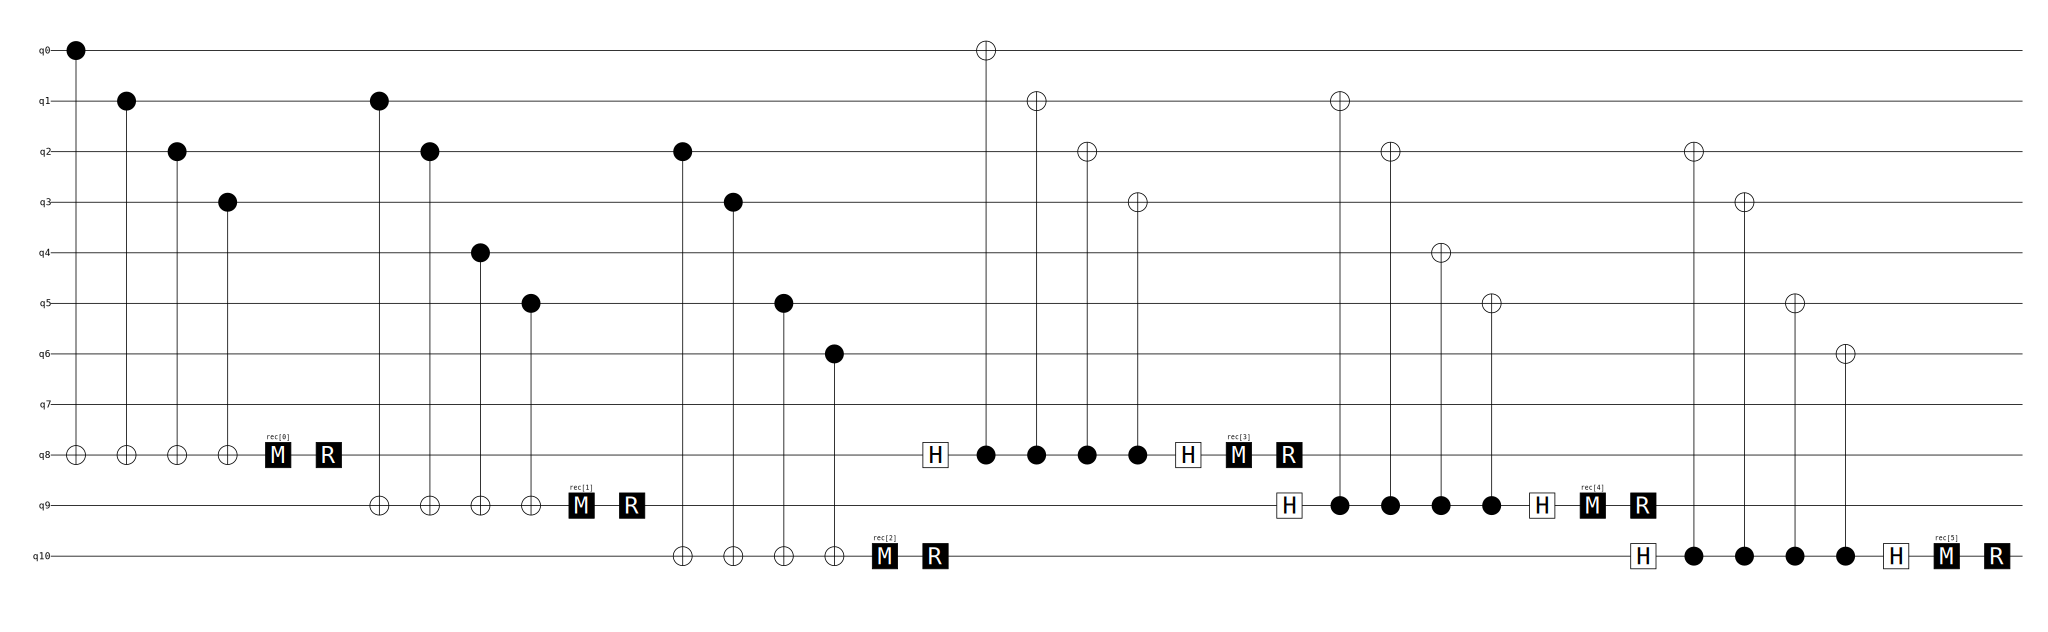

In [13]:
c = stim.Circuit()
c += measure_all_syndromes()
c.diagram("timeline-svg")

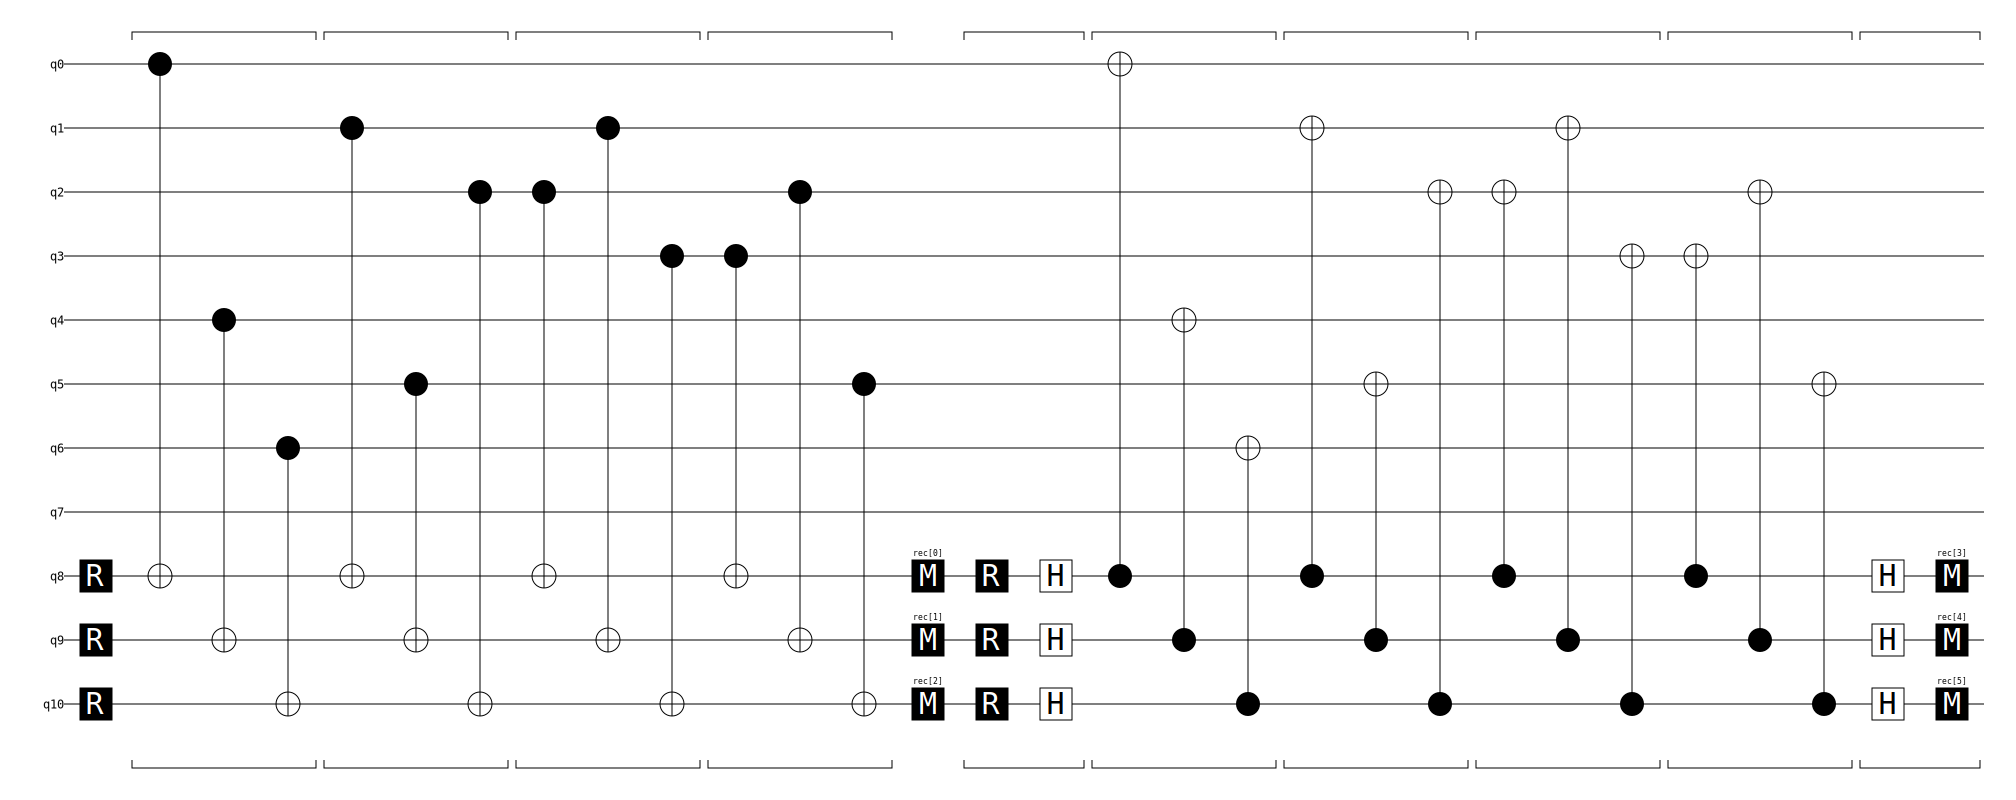

In [14]:
c = stim.Circuit()
c += measure_all_syndromes_3ancPara()
#c += noise.apply(measure_all_syndromes_3ancPara())
c.diagram("timeline-svg")

This approach for syndrome extraction is problematic as it is clearly not fault-tolerant. For example, consider a $Z$ error on one of the ancilla qubits. A single error can spread to 4 physical qubits during a single stabilizer measurement!

**Can we do better?**

A first approach could be to group the entangling gates, so that we measure the stabilizers in parallel. We can measure at most 3 stabilizers in parallel. This also reduces the time the physical qubits spent idling.

Furthermore, we need to consider the spreading of errors from the ancillas, so called **hook errors**. Since the Steane code is a distance $d=3$ code, we can at most correct a single error and detect two errors. 

A simple approach to detect hook errors is to add additional "flag" qubits, which measure parity checks on subsets of ancillas. In the following, we define circuits where the ancillas act themselves as flags for hook errors without the need for additional ancillas (Syndrome qubits reciprocally flag each other). 

In [15]:
def measure_flagged_syndromes_xzz() -> stim.Circuit:
    """Extracts flagged syndrome measurements for stabilizers 1, 5, 6

    1: XXXXIII  (Z errors on first plaquette)
    5: IZZIZZI  (X errors on second plaquette)
    6: IIZZIZZ  (X errors on third plaquette)
    """
    c = stim.Circuit()
    c.append("H", 8)
    c.append("CNOT", [8, 3])
    c.append("CNOT", [2, 10])
    c.append("CNOT", [5, 9])
    # correlate
    c.append("CNOT", [8, 9])
    c.append("CNOT", [8, 0])
    c.append("CNOT", [3, 10])
    c.append("CNOT", [4, 9])
    c.append("CNOT", [8, 1])
    c.append("CNOT", [6, 10])
    c.append("CNOT", [2, 9])
    # correlate
    c.append("CNOT", [8, 10])
    c.append("CNOT", [8, 2])
    c.append("CNOT", [5, 10])
    c.append("CNOT", [1, 9])
    c.append("H", 8)

    # measure ancillas and reset them
    c.append("M", [8, 9, 10])
    c.append("R", [8, 9, 10])
    return c

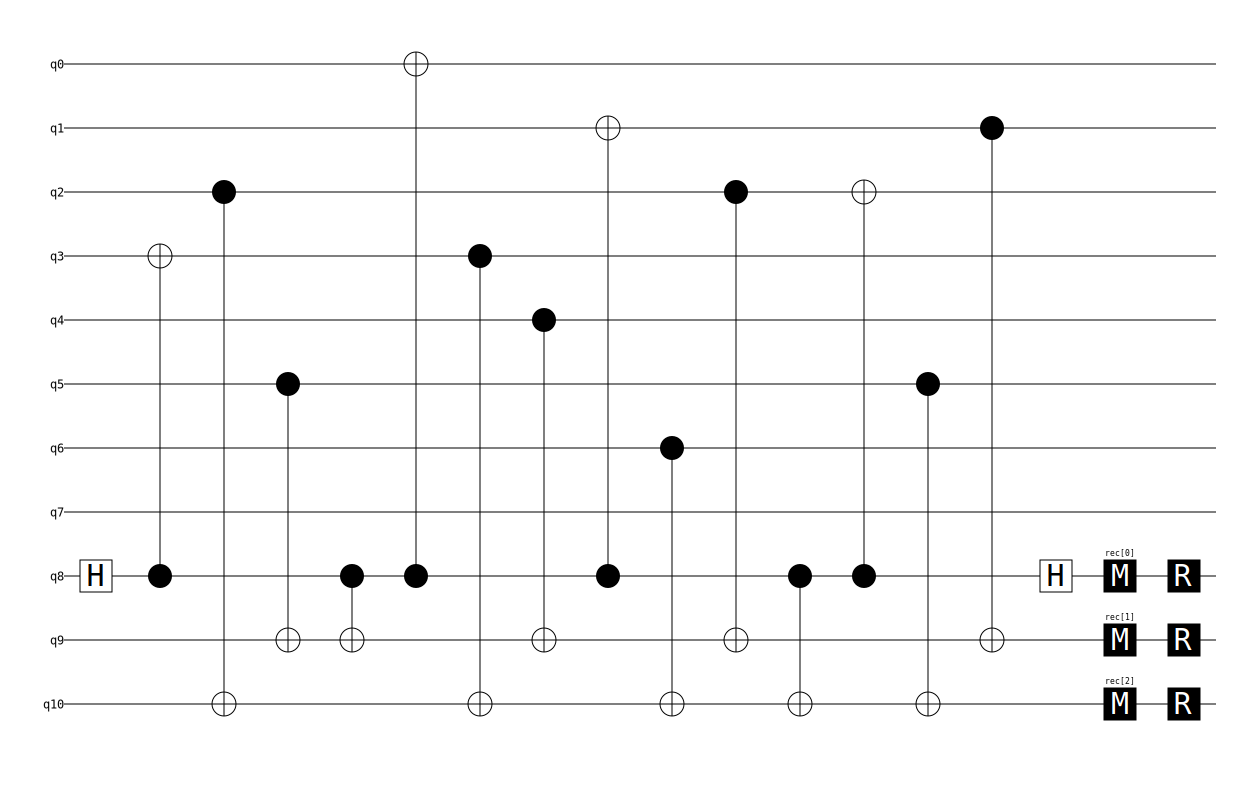

In [16]:
xzz = measure_flagged_syndromes_xzz()
xzz.diagram("timeline-svg")

In [17]:
def measure_flagged_syndromes_xzz_v2() -> stim.Circuit:
    """
    Extracts flagged syndrome measurements with TICKs added for noise modeling.
    
    Structure:
    - Ancilla 8 measures X-stabilizer (init H, end H)
    - Ancillas 9, 10 measure Z-stabilizers? (No H brackets in your code)
    - Flag CNOTs (8->9, 8->10) interleave the data checks.
    """
    c = stim.Circuit()

    # --- Step 1: Initialization ---
    # Assume ancillas start clean or reset them
    c.append("R", [8, 9, 10])
    c.append("TICK")
    
    # --- Step 2: Basis Prep & First Data Interaction ---
    # Ancilla 8 enters X-basis
    c.append("H", 8)
    
    # Parallel CNOTs: 8->3, 2->10, 5->9
    c.append("CNOT", [8, 3, 2, 10, 5, 9])
    c.append("TICK")

    # --- Step 3: First Flag/Correlation ---
    # 8 talks to 9. This blocks them from data interactions.
    # 10 is technically idle here, or could do an op if available.
    c.append("CNOT", [8, 9])
    c.append("TICK")

    # --- Step 4: Second Data Interaction ---
    # 8->0, 3->10, 4->9
    c.append("CNOT", [8, 0, 3, 10, 4, 9])
    c.append("TICK")

    # --- Step 5: Third Data Interaction ---
    # 8->1, 6->10, 2->9
    c.append("CNOT", [8, 1, 6, 10, 2, 9])
    c.append("TICK")

    # --- Step 6: Second Flag/Correlation ---
    # 8 talks to 10.
    c.append("CNOT", [8, 10])
    c.append("TICK")

    # --- Step 7: Fourth Data Interaction ---
    # 8->2, 5->10, 1->9
    c.append("CNOT", [8, 2, 5, 10, 1, 9])
    c.append("TICK")

    # --- Step 8: Basis Return ---
    # Return Ancilla 8 to Z-basis
    c.append("H", 8)
    c.append("TICK")

    # --- Step 9: Measurement & Reset ---
    c.append("M", [8, 9, 10])
    c.append("R", [8, 9, 10])
    c.append("TICK")

    return c

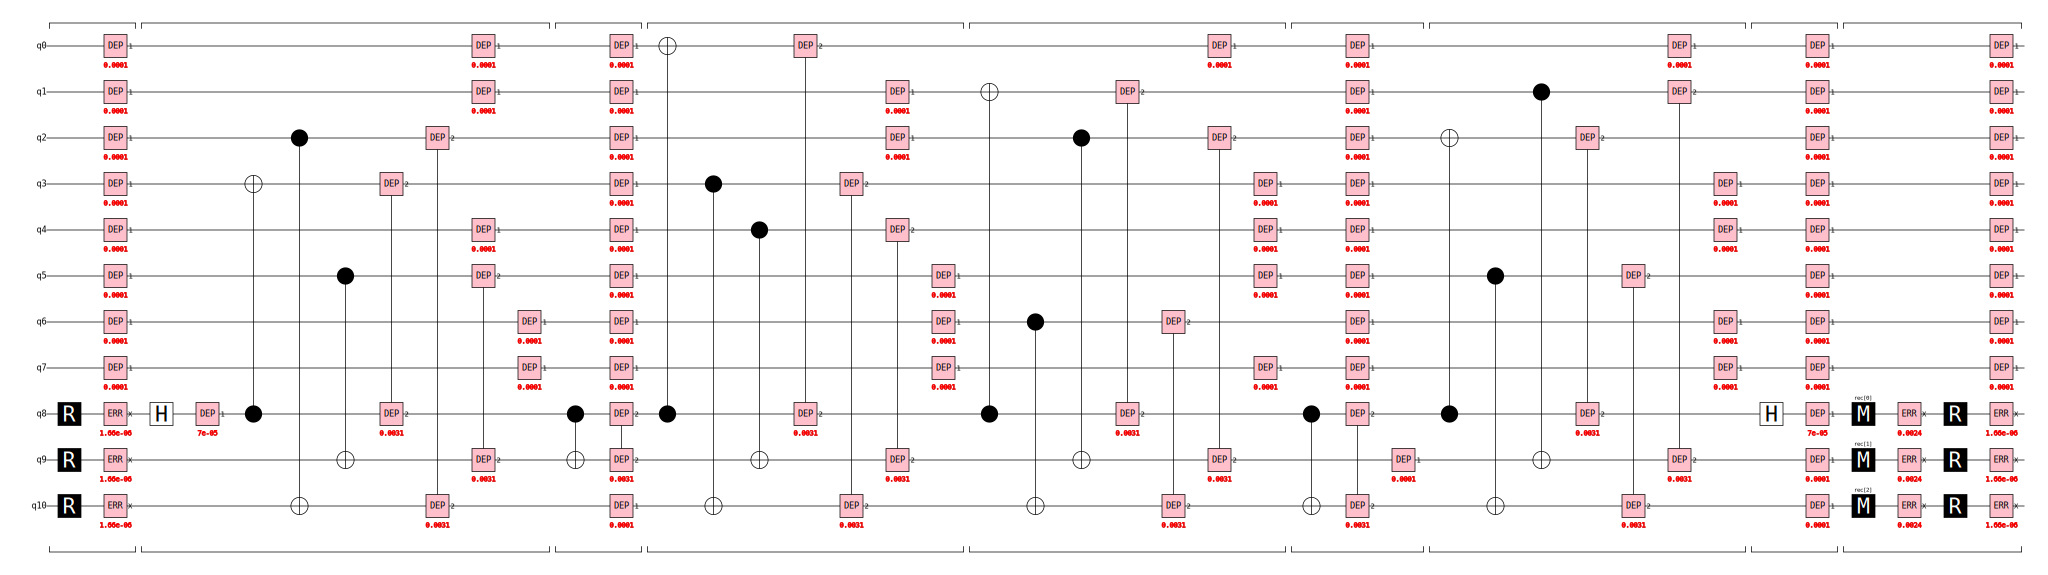

In [18]:
c = stim.Circuit()
#c += measure_flagged_syndromes_xzz_v2()
c += noise.apply(measure_flagged_syndromes_xzz_v2())
c.diagram("timeline-svg")

In [19]:
def measure_flagged_syndromes_zxx() -> stim.Circuit:
    """Extracts flagged syndrome measurements for stabilizers 2, 3, 4

    2: ZZZZIII  (X errors on first plaquette)
    3: IXXIXXI  (Z errors on second plaquette)
    4: IIXXIXX  (Z errors on third plaquette)
    """
    c = stim.Circuit()

    c.append("H", [9, 10])
    c.append("CNOT", [3, 8])
    c.append("CNOT", [10, 2])
    c.append("CNOT", [9, 5])
    # correlate
    c.append("CNOT", [9, 8])
    c.append("CNOT", [0, 8])
    c.append("CNOT", [10, 3])
    c.append("CNOT", [9, 4])
    c.append("CNOT", [1, 8])
    c.append("CNOT", [10, 6])
    c.append("CNOT", [9, 2])
    # correlate
    c.append("CNOT", [10, 8])
    c.append("CNOT", [2, 8])
    c.append("CNOT", [10, 5])
    c.append("CNOT", [9, 1])
    c.append("H", [9, 10])

    # measure ancillas and reset them
    c.append("M", [8, 9, 10])
    c.append("R", [8, 9, 10])
    return c


An example of hook errors with flags is shown in the picture below, taken from the Quantinuum paper:

![Steane Hook Errors](img/quantinuum-steane-hook-errors.png)

In [20]:
def measure_flagged_syndromes_zxx_v2() -> stim.Circuit:
    """
    Extracts flagged syndrome measurements for stabilizers 2, 3, 4 with TICKs.
    
    Stabilizers:
    2 (Z-check on 0,1,2,3) -> Ancilla 8 (Z-basis)
    3 (X-check on 1,2,4,5) -> Ancilla 9 (X-basis)
    4 (X-check on 2,3,5,6) -> Ancilla 10 (X-basis)
    
    Structure:
    - Ancilla 8 is Z-basis (Target of data CNOTs)
    - Ancillas 9, 10 are X-basis (Control of data CNOTs, wrapped in H)
    - Flag 1: 9->8 (Correlates Stab 3 and 2)
    - Flag 2: 10->8 (Correlates Stab 4 and 2)
    """
    c = stim.Circuit()

    # --- Step 1: Initialization ---
    c.append("R", [8, 9, 10])
    c.append("TICK")

    # --- Step 2: Basis Prep ---
    # 9, 10 go to X-basis
    c.append("H", [9, 10])
    c.append("TICK")

    # --- Step 3: First Data Interaction ---
    # 8(T)<-3, 10(C)->2, 9(C)->5
    c.append("CNOT", [3, 8, 10, 2, 9, 5])
    c.append("TICK")

    # --- Step 4: First Flag & Parallel Data ---
    # Flag: 9->8
    # Parallel: 10->3 (10 is free, 3 is free)
    c.append("CNOT", [9, 8, 10, 3])
    c.append("TICK")

    # --- Step 5: Second Data Interaction ---
    # 8(T)<-0, 9(C)->4, 10(C)->6
    c.append("CNOT", [0, 8, 9, 4, 10, 6])
    c.append("TICK")

    # --- Step 6: Third Data Interaction ---
    # 8(T)<-1, 9(C)->2
    # 10 is idle here (waiting for 8 to free up for the next flag)
    c.append("CNOT", [1, 8, 9, 2])
    c.append("TICK")

    # --- Step 7: Second Flag & Parallel Data ---
    # Flag: 10->8
    # Parallel: 9->1 (9 is free, 1 is free)
    c.append("CNOT", [10, 8, 9, 1])
    c.append("TICK")

    # --- Step 8: Fourth Data Interaction ---
    # 8(T)<-2, 10(C)->5
    # 9 is idle/done
    c.append("CNOT", [2, 8, 10, 5])
    c.append("TICK")

    # --- Step 9: Basis Return ---
    # Return 9, 10 to Z-basis
    c.append("H", [9, 10])
    c.append("TICK")

    # --- Step 10: Measurement & Reset ---
    c.append("M", [8, 9, 10])
    c.append("R", [8, 9, 10])
    c.append("TICK")

    return c

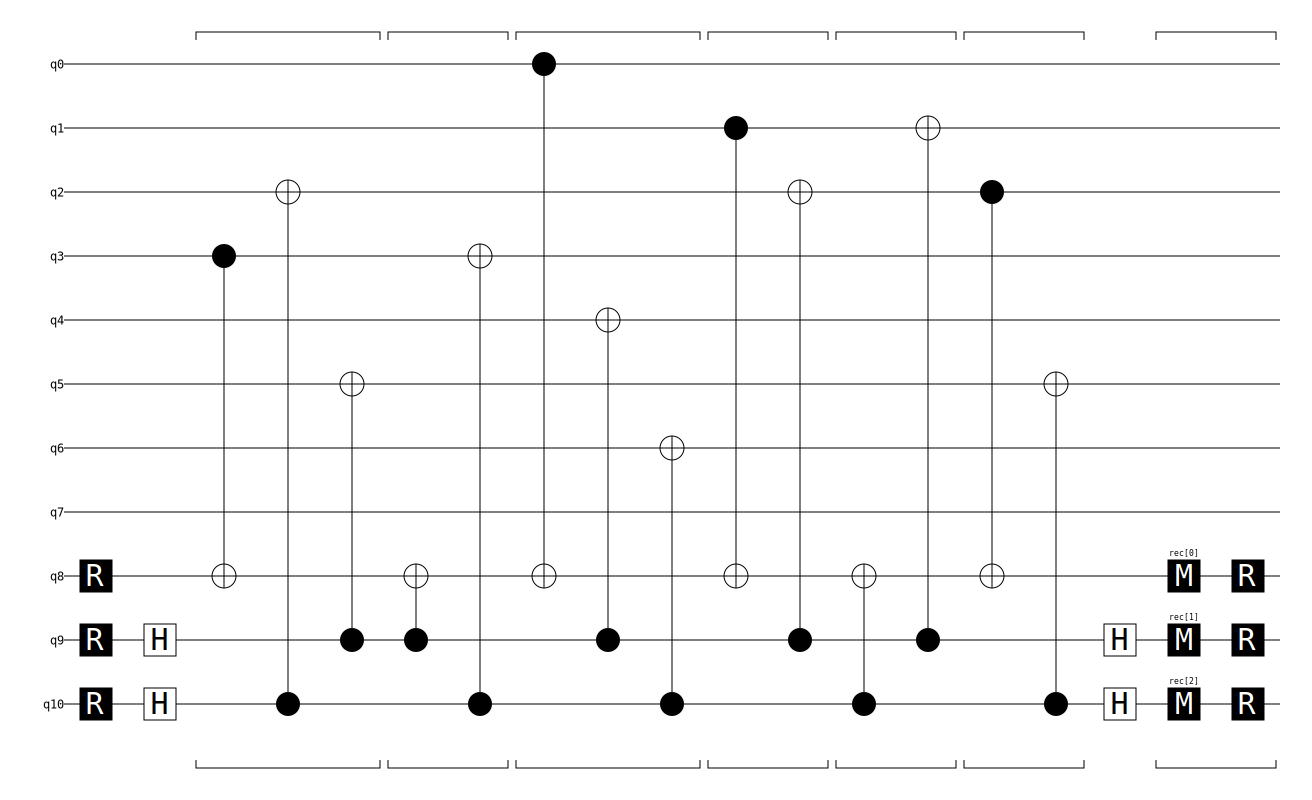

In [21]:
c = stim.Circuit()
c += measure_flagged_syndromes_zxx_v2()
#c += noise.apply(measure_flagged_syndromes_zxx_v2())
c.diagram("timeline-svg")

### Different Basis State Preparation

We can prepare the state $| 0 \rangle_L$ with the method above. Next, we'll want to prepare the logical qubit in different basis states

$$ \{ |0\rangle_L, |1\rangle_L, |+\rangle_L, |-\rangle_L, |+i\rangle_L, |-i\rangle_L \} $$

This can easily be done by using the logical gates $X_L, Z_L, S_L$, and $H_L$, that we identified in the previous section.

In [22]:
def logical_single_qubit_gate(gate: str, log_qb_idx: int = 0) -> stim.Circuit:
    """
    Supported logical gates:
        - "Z": Logical Z gate
        - "X": Logical X gate
        - "H": Logical Hadamard gate
        - "S": Logical S (phase) gate

    Args:
        c (stim.Circuit): The stim object to append the logical gate to
        gate (str): The name of the logical gate to apply.
                    Must be one of: "Z", "X", "H", "S"
        log_qb_idx (int, optional): Index of the logical qubit to operate on.
                                    Used to offset the physical qubit indices
                                    when working with multiple logical qubits.
                                    Defaults to 0.
                                    Each logical qubit uses 8 physical qubits
                                    (7 data + 1 ancilla).

    Returns:
        stim.Circuit: The modified circuit with the logical gate appended
    """
    c = stim.Circuit()
    # shift registers to target logical qubit with given index
    s = log_qb_idx * 8

    match gate:
        case "Z":
            c.append("Z", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
        case "X":
            c.append("X", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
        case "H":
            c.append("H", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
        case "S":
            c.append("S", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
        case "S_DAG":
            c.append("S_DAG", np.array([0, 1, 2, 3, 4, 5, 6]) + s)
        case _:
            raise ValueError("Logical gate name '{logical_gate}' undefined")

    return c

In [23]:
# We define a helper function to prepare the logical qubit in the Eigenstate of a given Stabilizer
# applies a sequence of Logical Gates to transform it into one of the 6 cardinal states on the Bloch sphere.
def prepare_stab_eigenstate(stabilizer: str) -> stim.Circuit:
    """Generates a circuit preparing the Eigenstate of a given singe-qubit stabilizer"""

    c = stim.Circuit()

    match stabilizer:
        case "+Z":  # |0>
            pass
        case "-Z":  # |1>
            c += logical_single_qubit_gate(gate="X")
        case "+X":  # |+>
            c += logical_single_qubit_gate(gate="H")
        case "-X":  # |->
            c += logical_single_qubit_gate(gate="X")
            c += logical_single_qubit_gate(gate="H")
        case "+Y":  # |+i>
            c += logical_single_qubit_gate(gate="H")
            c += logical_single_qubit_gate(gate="S")
        case "-Y":  # |-i>
            c += logical_single_qubit_gate(gate="X")
            c += logical_single_qubit_gate(gate="H")
            c += logical_single_qubit_gate(gate="S")
        case _:
            raise ValueError(f"Unknown stabilizer {stabilizer}")

    return c

In [24]:
def rotate_to_measurement_basis(meas_basis: str) -> stim.Circuit:
    """Appends single-qubit rotations to a circuit to prepare
    measurement in specified basis"""
    c = stim.Circuit()

    match meas_basis:
        case "Z":
            pass
        case "X":
            c += logical_single_qubit_gate(gate="H")
        case "Y":
            c += logical_single_qubit_gate(gate="S_DAG")
            c += logical_single_qubit_gate(gate="H")
        case _:
            raise ValueError("Specified target basis not known")

    return c

### Full QEC cycle

We are nearly ready to run our full QEC cycle. We can now come up with a protocol to reliably correct a single physical qubit error. Our flagged syndrome circuits can detect hook errors. To differentiate them from heigher weight Pauli errors, we combine flagged and unflagged syndrome extraction.

If the flagged syndrome circuits do not indicate an error, than we are done and the next QEC cycle starts. Otherwise, we know that an error occurred, but we need to measure the complete set of stabilizers to identify whether a hook error occurred. 

This combination of conditional syndrome extraction is also known as **adaptive syndrome extraction** and can reduce average QEC cycle time significantly.

The adaptive QEC cycle is depicted in the picture below:

![](img/qec_cycle_with_flagged_syndromes.png)

Unfortunately, Stim does not support conditional circuit execution, which means that we need to drive the `TableauSimulator` manually.

In [25]:
# define a logger allowing us to print the progress of the execution of the QEC experiment
import logging
logging.basicConfig(format="%(message)s")

### The Decoder

The decoder is a simple two-stage **Lookup Table Decoder (LUT)**. This means that for each syndrome pattern there is a fixed rule on how to update the **Pauli Frame**, which indicates whether the logical qubit has been flipped or not.

The first stage is used to decode the unflagged syndromes and the second stage decodes the flagged syndromes.

$X$/$Z$-type errors are handled separately, but since the stabilizers have the same structure we can use the same LUT decoder.

> **Note:** We don't provide the syndromes directly to the decoder but only whether the syndromes changed between QEC cycle rounds.

In [26]:
def unflagged_decoder(syndromes: np.array) -> int:
    """Given X-/Z-type stabilizer measurements.

    The syndromes are used to infer whether a logical error has occurred

    This is exactly the case, when there is a change in syndromes
    for the 2nd/3rd stabilizer.
    """
    bad_syndrome_patterns = np.array([[0, 0, 1], [0, 1, 0], [0, 1, 1]])

    if np.any(np.all(bad_syndrome_patterns == syndromes, axis=1)):
        logging.debug("Unflagged decoder: Logical error detected!")
        return 1
    else:
        return 0


def flagged_decoder(syndromes: np.array, flagged_syndromes: np.array) -> int:
    """
    Handle hook errors.
    """

    if np.all(flagged_syndromes == [1, 0, 0]) and np.all(syndromes == [0, 1, 0]):
        return 1
    elif np.all(flagged_syndromes == [1, 0, 0]) and np.all(syndromes == [0, 0, 1]):
        return 1
    elif np.all(flagged_syndromes == [0, 1, 1]) and np.all(syndromes == [0, 0, 1]):
        return 1
    else:
        return 0


def decoder(syndromes: np.array, flagged_syndromes: np.array) -> list[int, int]:
    pf = unflagged_decoder(syndromes)
    pf_flag = flagged_decoder(syndromes, flagged_syndromes)

    return pf, pf_flag

In [27]:
def qec_cycle(
    simulator: stim.TableauSimulator,
    x_syndromes: np.array,
    z_syndromes: np.array,
    pauli_frame: np.array,
    m_idx: int,
    noise: NoiseModel,
) -> int:
    """Run a full QEC cycle for the [[7,1,3]]-Steane code
    by driving the Tableau simulator manually"""

    # track the delta of previous and current syndrome measurement
    flag_diff_x = np.array([0, 0, 0])  # track delta of X-stabilizers
    flag_diff_z = np.array([0, 0, 0])  # track delta of Z-stabilizers

    # first flagged syndrome extraction
    simulator.do(noise.apply(measure_flagged_syndromes_xzz()))
    # measure first X-stabilizer, and second/third Z-stabilizer
    fx0, fz1, fz2 = simulator.current_measurement_record()[m_idx : m_idx + 4]
    # update syndrome delta
    flag_diff_x[0] = fx0 ^ x_syndromes[0]
    flag_diff_z[1] = fz1 ^ z_syndromes[1]
    flag_diff_z[2] = fz2 ^ z_syndromes[2]
    # shift measurement index
    m_idx += 3
    # print delta for debugging
    logging.debug(
        f"Delta after 1st flagged measurement (XZZ): X {flag_diff_x}, Z {flag_diff_z}"
    )

    # if no syndrome changed continue with second round of flagged syndrome measurements
    if np.all(flag_diff_x == 0) and np.all(flag_diff_z == 0):
        # second flagged syndrome extraction
        simulator.do(noise.apply(measure_flagged_syndromes_zxx()))
        # measure first Z-stabilizer, and second/third X-stabilizer
        fz0, fx1, fx2 = simulator.current_measurement_record()[m_idx : m_idx + 4]
        # update syndrome delta
        flag_diff_z[0] = fz0 ^ z_syndromes[0]
        flag_diff_x[1] = fx1 ^ x_syndromes[1]
        flag_diff_x[2] = fx2 ^ x_syndromes[2]
        # shift measurement index
        m_idx += 3
        # print delta for debugging
        logging.debug(
            f"Delta after 2nd flagged measurement (ZXX): X {flag_diff_x}, Z {flag_diff_z}"
        )

    # re-measure all syndromes if flagged syndrome
    # extraction indicates changes in syndromes
    if np.any(flag_diff_z == 1) or np.any(flag_diff_x == 1):
        # run full syndrome extraction
        simulator.do(noise.apply(measure_all_syndromes()))
        s = simulator.current_measurement_record()[m_idx : m_idx + 7]
        # update syndromes
        current_z_syndromes = np.array(
            s[0:3], dtype=int
        )  # First 3 measurements Z-stabilizers
        current_x_syndromes = np.array(
            s[3::], dtype=int
        )  # Final 3 measurements X-stabilizers
        # compute delta
        diff_x_syndromes = x_syndromes ^ current_x_syndromes
        diff_z_syndromes = z_syndromes ^ current_z_syndromes
        # shift measurement index
        m_idx += 6
        # print new syndrome measurements
        logging.debug(
            f"Delta after unflagged measurement: "
            f"X:{diff_x_syndromes}, Z:{diff_z_syndromes}"
        )

        # call decoder to get updated pauli frame
        pf_x, pf_flag_x = decoder(diff_x_syndromes, flag_diff_x)
        pf_z, pf_flag_z = decoder(diff_z_syndromes, flag_diff_z)

        # update pauli frame
        pauli_frame[0] = pauli_frame[0] ^ pf_x ^ pf_flag_x
        pauli_frame[1] = pauli_frame[1] ^ pf_z ^ pf_flag_z
        logging.debug(f"Pauli frame: Z: {pauli_frame[0]}, X: {pauli_frame[1]}")

        # update syndromes
        x_syndromes = current_x_syndromes
        z_syndromes = current_z_syndromes

    return simulator, x_syndromes, z_syndromes, pauli_frame, m_idx

For the final round of quantum error correction, we measure all physical qubits simultaneously in the $Z$-basis.

Given the measurement results, we compute the syndrome measurements as well as the logical observable by classically XORing the bits.

Depending on the chosen measurement basis, we need to modify the syndromes.

In [58]:
def destructive_logical_measurement(
    simulator: stim.TableauSimulator,
    meas_basis: str,
    x_syndromes: np.array,
    z_syndromes: np.array,
    pauli_frame: np.array,
    m_idx: int,
    noise: NoiseModel,
) -> int:
    """Perform final destructive measurement where all physical qubits are measured.

    Returns a single bit, corresponding to the logical qubit measurement in the
    specified measurement basis. A final set of syndromes can be computed depending
    on the measurement basis.
    """

    # Measure all seven physical qubits of our logical qubit destructively
    simulator.do(noise.apply(measure_logical_qubits()))
    r = simulator.current_measurement_record()[m_idx : m_idx + 7]

    # Compute the logical observable
    log_obs = r[4] ^ r[5] ^ r[6]

    # Compute syndromes
    s1 = r[0] ^ r[1] ^ r[2] ^ r[3]  # First plaquette
    s2 = r[1] ^ r[2] ^ r[4] ^ r[5]  # Second plaquette
    s3 = r[2] ^ r[3] ^ r[5] ^ r[6]  # Third plaquette
    syndromes = np.array([s1, s2, s3], dtype=int)

    match meas_basis:
        case "X":
            syndrome_diff = syndromes ^ x_syndromes
        case "Y":
            # Correct logic: The Y-basis syndrome is the parity of X and Z syndromes
            syndrome_diff = syndromes ^ x_syndromes ^ z_syndromes
        case "Z":
            syndrome_diff = syndromes ^ z_syndromes
        case _:
            raise ValueError(f"Unknown measurement basis {meas_basis}!")

    logging.debug(f"Delta final round: {syndrome_diff}")

    # Get final corrections from the unflagged decoder
    final_correction = unflagged_decoder(syndrome_diff)

    # Update the logical obs
    log_obs = log_obs ^ final_correction

    # Finally, apply correction based on measurement basis
    match meas_basis:
        case "X":
            log_obs = log_obs ^ pauli_frame[0]
        case "Y":
            log_obs = log_obs ^ pauli_frame[0] ^ pauli_frame[1]
            logging.debug("log : %s, pf: %s", log_obs, pauli_frame)
        case "Z":
            log_obs = log_obs ^ pauli_frame[1]

    return log_obs

In [29]:
def expected_result(measure_output: int, stabilizer: str, meas_basis: str) -> int:
    """Evaluate if measurement corresponds to the expected measurement
    result for a given stabilizer and measurement basis."""

    pauli_measurement = stim.PauliString(meas_basis)
    pauli_stabilizer = stim.PauliString(stabilizer)
    commute = pauli_stabilizer.commutes(pauli_measurement)

    if not commute:
        raise ValueError("Anti-commuting stabilzers, measurement is random")

    sign = (pauli_measurement * pauli_stabilizer).sign

    if sign == 1:
        return int(0 == measure_output)
    else:
        return int(1 == measure_output)

Finally, we can put everything together and run the whole QEC cycle!

In [30]:
def steane_code_exp(
    initial_state: str = "+Z",
    meas_basis: str = "Z",
    num_cycles: int = 1,
    shots: int = 100,
    noise=NoiseModel(type='H1-1'),
):
    """Runs an error correction experiment for the Steane [[7,1,3]]-code.

    The quantum state is represented by the state of the stim TableauSimulator.
    """
    results = []

    dbgShot=3
    
    for ishot in range(shots):
        simulator = stim.TableauSimulator()

        m_idx = 0  # shift measurement index

        # state preparation (3 attempts)
        # prepare the logical |0>_L state and verify with ancilla
        for _ in range(3):
            simulator.do(noise.apply(encoding_circuit()))
            state_prep_ancilla = simulator.current_measurement_record()[m_idx]
            if ishot<dbgShot: logging.debug("State preparation ancilla: %s", int(state_prep_ancilla))
            m_idx += 1
            if not state_prep_ancilla:
                break

        # apply single qubit gate to prepare correct state
        simulator.do(noise.apply(prepare_stab_eigenstate(initial_state)))

        # run QEC cycles
        x_syndromes = np.array([0, 0, 0])
        z_syndromes = np.array([0, 0, 0])
        # Pauli frame tracks which logical correction to apply
        # Pauli Frame = [Apply X_L?, Apply Z_L?]
        pauli_frame = np.array([0, 0])

        for i in range(num_cycles):
            if ishot<dbgShot: logging.debug(f"--- QEC cycle {i}  ishot {ishot}")
            simulator, x_syndromes, z_syndromes, pauli_frame, m_idx = qec_cycle(
                simulator, x_syndromes, z_syndromes, pauli_frame, m_idx, noise
            )

        # Rotate to correct logical measurement basis
        simulator.do(noise.apply(rotate_to_measurement_basis(meas_basis=meas_basis)))

        # Perform final destructive logical measurement
        final_measurement = destructive_logical_measurement(
            simulator, meas_basis, x_syndromes, z_syndromes, pauli_frame, m_idx, noise
        )

        if ishot<dbgShot: logging.debug(f"Final measurement: {final_measurement}")

        success = expected_result(final_measurement, initial_state, meas_basis)
        if ishot<dbgShot: logging.debug(f"Success: {success}\n")
        results.append(success)

    return results

noise type= H1-1


In [31]:
# Uncomment to follow QEC cycle execution
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)

noise = NoiseModel(type='H1-1')
noise.enabled = False

steane_code_exp(num_cycles=3, shots=1, initial_state="+Y", meas_basis="Y", noise=noise)

noise type= H1-1


[1]

### Simulating Logical Error Rates for Steane Code for each Basis

In [68]:
shots = 4000 # 2048
cycles_sweep = [0, 1, 2, 4, 6, 8,12]
basis_sweep = ["Z", "X", "Y"]
noise = NoiseModel('H2-1')
noise.enabled = True
from time import time
T0=time()
results = []
for basis in basis_sweep:
    cycle_results = []
    for cycles in cycles_sweep:
        exp_results = steane_code_exp(
            num_cycles=cycles,
            shots=shots,
            initial_state=f"+{basis}",
            meas_basis=f"{basis}",
            noise=noise,
        )
        pr=np.sum(exp_results) / shots
        if pr>0 and pr<1 :
            epr=np.sqrt(pr*(1-pr)/shots)
        else:
            epr=1/shots
        cycle_results.append([pr,epr])
    results.append(cycle_results)
elaT=time()-T0
results=np.array(results)
print(f'res:{results.shape}   elaT/sec:{elaT:.1f}')

noise type= H2-1
res:(3, 7, 2)   elaT/sec:863.6


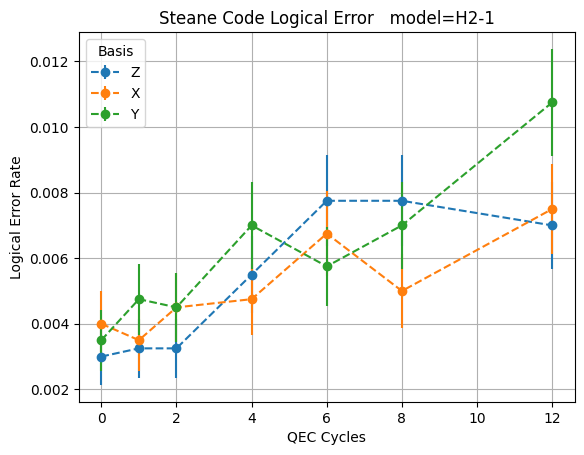

In [69]:
plt.title("Steane Code Logical Error   model=%s"%noise.type)
plt.xlabel("QEC Cycles")
plt.ylabel("Logical Error Rate")
plt.grid() #axis="y")
#plt.yscale("log")

for idx, basis in enumerate(basis_sweep):
    prV=results[idx,:,0]
    errV=results[idx,:,1]
    plt.errorbar(cycles_sweep,1-prV,yerr=errV,fmt='o--', label=basis)
plt.legend(title="Basis")

For the Steane [[7,1,3]] code, the set of gates that can be implemented transversally is unusually large, which is one of the code's main features.

Here is the summary of which gates are transversal and which are not:

### 1. Fully Transversal (Bitwise)

These gates are implemented by applying the single-qubit version of the gate to all 7 physical qubits simultaneously.

* **Pauli Gates ():**
* Applying  implements Logical .
* Applying  implements Logical .
* Applying  implements Logical  (up to a global phase).
* **Why:** The code distance is 3 (odd), and the stabilizers commute/anti-commute in a way that preserves the code space.


* **Hadamard ():**
* Applying  implements Logical .
* **Why:** The Steane code is a CSS code where the X and Z stabilizers are symmetric (the parity check matrix  is the same for both). Swapping X and Z via Hadamard maps the stabilizer group to itself.


* **CNOT ():**
* Applying  between two separate blocks of 7 qubits (Block A  Block B) implements a Logical CNOT.
* **Why:** CNOT propagates X forward and Z backward. Since the code corrects both X and Z errors separately, this propagation preserves the code structure.



### 2. Transversal with Permutation

This is likely the source of the "Y-basis bug" you encountered earlier.

* **Phase Gate ():**
* **You cannot simply apply .** If you do, you map X-stabilizers to Y-stabilizers, taking the state out of the code space (unless you correct it).
* **The Solution:** To implement a Logical , you must apply  to all 7 qubits **AND** permute the qubits (swap indices).
* Because of this requirement,  is often listed as "transversal" in literature (because it doesn't spread errors), but it is not "bitwise" like H or X.



### 3. NOT Transversal

These gates **cannot** be implemented transversally for the Steane code.

* **T Gate ( gate):**
* This is non-Clifford. The Eastin-Knill theorem proves that no Quantum Error Correcting Code can have a transversal universal gate set. Since Steane has transversal Clifford gates, it *cannot* have a transversal T gate.
* **Workaround:** You must use "Magic State Injection" (prepare a noisy  state and teleport the gate into the code).



### Summary Table

| Logical Gate | Physical Implementation | Transversal? |
| --- | --- | --- |
| **X, Y, Z** |  | **Yes** |
| **Hadamard (H)** |  | **Yes** |
| **CNOT** |  (Block A  Block B) | **Yes** |
| **Phase (S)** |  + **Permutation** | **Yes (with swaps)** |
| **T Gate** | N/A | **No** (Magic State required) |

**Recommendation for your Simulation:**
Since implementing the permutation for  is annoying in a static circuit, avoid testing the Y-basis using the "Prep " method. Instead, just trust the X and Z basis tests, which cover all error types for this code.


#### Correct Logical S gate (keeps state in code space)

c.append("S_DAG", [0, 1, 2, 3, 4, 5, 6]

c.append("SWAP", [3, 5]) # Step 1 of cyclic shift

c.append("SWAP", [5, 6]) # Step 2 of cyclic shift

But again, you do not need this for your current experiment. Just fixing the syndrome_diff typo will solve your problem.